# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.031448,True,3.988365
1,-0.780643,False,1.834933
2,0.840619,True,4.133772
3,0.991618,True,3.265256
4,0.378879,False,0.063881
...,...,...,...
995,-1.564511,False,0.698218
996,-0.186787,False,-1.236308
997,-1.451326,True,5.979424
998,-0.834280,False,-1.293601


<Axes: xlabel='v0'>

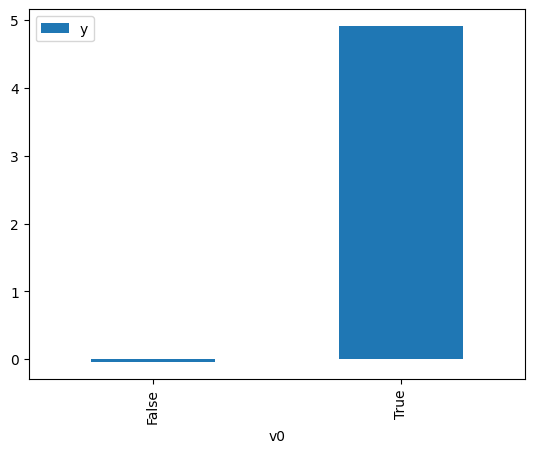

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

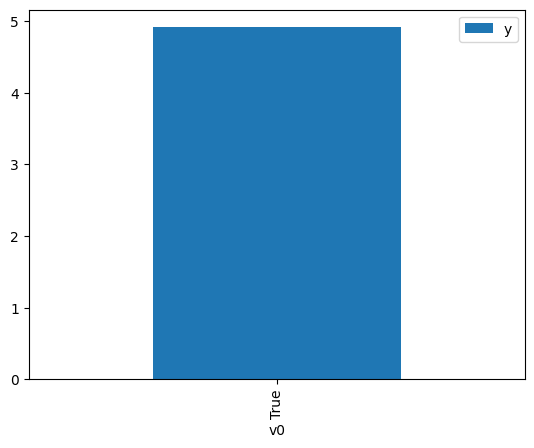

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.576599,False,0.610484,0.622316,1.606902
1,-0.685109,False,-1.055249,0.641889,1.557902
2,-1.691911,False,-0.763180,0.796517,1.255466
3,-0.733091,False,-0.326658,0.650400,1.537516
4,-0.386778,False,-0.597250,0.587132,1.703194
...,...,...,...,...,...
995,-1.229568,False,-1.581741,0.732231,1.365689
996,-0.964894,False,-0.278329,0.690110,1.449044
997,-0.318041,False,-0.854561,0.574148,1.741711
998,-0.304986,False,-0.398277,0.571670,1.749262


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.943465,True,6.888791,0.173672,5.757984
1,-2.080417,True,3.755048,0.158948,6.291353
2,-0.671861,True,4.857774,0.360477,2.774102
3,-0.748428,True,5.286265,0.346899,2.882680
4,-2.368257,True,4.392190,0.131315,7.615296
...,...,...,...,...,...
995,1.092377,True,5.202133,0.688996,1.451388
996,-0.022865,True,6.160811,0.482559,2.072286
997,-0.480733,True,4.602393,0.395318,2.529611
998,-0.175168,True,4.086544,0.453150,2.206776


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                              5789.
Date:                Wed, 22 Nov 2023   Prob (F-statistic):                        0.00
Time:                        15:11:56   Log-Likelihood:                         -1413.1
No. Observations:                1000   AIC:                                      2830.
Df Residuals:                     998   BIC:                                      2840.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1409      0.031      4.532      0.000       0.080       0.202
x2             4.9777      0.047    106.075      0.000       4.886       5.070
==============================================================================
Omnibus:                        1.317   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.518   Jarque-Bera (JB):                1.188
Skew:                           0.048   Prob(JB):                        0.552
Kurtosis:                       3.139   Cond. No.                         1.54
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""